In [11]:
%install_ext https://raw.github.com/cpcloud/ipython-autotime/master/autotime.py
%load_ext autotime

Installed autotime.py. To use it, type:
  %load_ext autotime


/home/eecs/vaishaal/anaconda2/lib/python2.7/site-packages/IPython/core/magics/extension.py:47: UserWarning: %install_ext` is deprecated, please distribute your extension(s)as a python packages.
  "as a python packages.", UserWarning)


In [86]:
%pylab inline
from snakebite.client import Client
import pyaml as yaml
import sys
import pythonrun
reload(pythonrun)
import os
import seaborn as sns
from sklearn import metrics
import scala_python_endive_wrapper
reload(scala_python_endive_wrapper)
from scala_python_endive_wrapper import *

Populating the interactive namespace from numpy and matplotlib
time: 13.5 ms


`%matplotlib` prevents importing * from pylab and numpy


In [2]:
hdfsclient = Client("amp-spark-master.amp", 8020, use_trash=False)
notebook_stdout = sys.stdout
notebook_stderr = sys.stderr
terminal_stdout = open('/dev/stdout', 'w')
terminal_stderr = open('/dev/stderr', 'w')
logpath = "/tmp/log"

In [24]:

executor_mem = "100g"
cores_per_executor = 32
num_executors = 14

In [51]:
# CHANGE ME
dataset_creation_config = \
{
    "labels": "/user/vaishaal/endive-data/ChIPseq/labels/EGR1.train.labels.tsv", \
    "reference": "/home/eecs/akmorrow/ADAM/endive/workfiles/hg19.2bit", \
    "dnase": "/user/vaishaal/endive-data/DNASE/peaks/relaxed/", \
    "aggregatedSequenceOutput": "/user/vaishaal/endive-data/aggregated/EGR1/"
}

EGR1_PATH = "/user/vaishaal/endive-data/aggregated/EGR1/EGR1"
ATF2_PATH = "/user/vaishaal/endive-data/aggregated/ATF2/ATF2"


time: 6.71 ms


In [21]:
# Run scala job send output to terminal to create windows
sys.stdout = terminal_stdout
sys.stderr = terminal_stderr
pythonrun.run(dataset_creation_config, 
              logpath,
              dataset_creation_pipeline_class, 
              pipeline_jar, 
              executor_mem,
              cores_per_executor, 
              num_executors,
              use_yarn=True)

In [28]:
sys.stdout = notebook_stdout
sys.stderr = notebook_stderr
os.system("mkdir -p {0}".format(kernel_pipeline_config["predictionsOutput"]))

0

time: 12.2 ms


In [ ]:
# this is where the magic happens
((y_train, y_train_pred), (y_test, y_test_pred)) = run_kernel_pipeline(EGR1_PATH,
                                                                       "/tmp/filters.csv", 
                                                                       logpath, 
                                                                       filter_gen_gen=make_gaussian_filter_gen,
                                                                       reg=1e-8,
                                                                       negativeSamplingFreq=0.1)

#### ROC Metrics

Train AUC 0.905775637466
Test AUC 0.890266688574


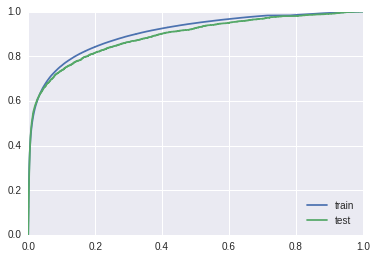

time: 2.73 s


In [93]:
sys.stdout = notebook_stdout
sys.stderr = notebook_stderr
fpr, tpr, thresh = metrics.roc_curve(y_train, y_train_pred)
train_auc = metrics.roc_auc_score(y_train, y_train_pred)
plot(fpr, tpr, label="train")

fpr, tpr, thresh = metrics.roc_curve(y_test, y_test_pred)
test_auc = metrics.roc_auc_score(y_test, y_test_pred)

plot(fpr, tpr, label="test")

plt.legend(loc=4)
plt.figure()
print("Train AUC {0}".format(train_auc))
print("Test AUC {0}".format(test_auc))

#### PR Metrics

Train PR AUC 0.757754546452
Test PR AUC 0.121105773929


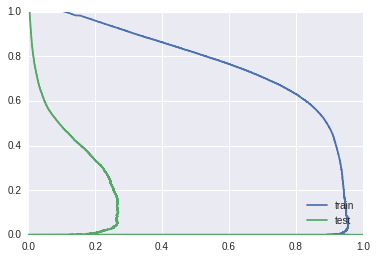

time: 2.96 s


In [68]:
sys.stdout = notebook_stdout
sys.stderr = notebook_stderr
fpr, tpr, thresh = metrics.precision_recall_curve(y_train, y_train_pred)
train_auc = metrics.average_precision_score(y_train, y_train_pred)
plot(fpr, tpr, label="train")

fpr, tpr, thresh = metrics.precision_recall_curve(y_test, y_test_pred)
test_auc = metrics.average_precision_score(y_test, y_test_pred)

plot(fpr, tpr, label="test")

plt.legend(loc=4)
plt.figure()
print("Train PR AUC {0}".format(train_auc))
print("Test PR AUC {0}".format(test_auc))

In [92]:
print("HI")

HI
time: 1.83 ms
